In [ ]:
!pip install git+https://github.com/maciejkula/spotlight.git@master#egg=spotlight
!pip install scikit-surprise
!pip install lightfm

  Cloning https://github.com/maciejkula/spotlight.git (to revision master) to /tmp/pip-install-joknqyj6/spotlight
  Running command git clone -q https://github.com/maciejkula/spotlight.git /tmp/pip-install-joknqyj6/spotlight
  Created wheel for spotlight: filename=spotlight-0.1.6-cp36-none-any.whl size=33921 sha256=b02b8d43312251bbd4e4f2331c5119455413862f8ede045821fb800eaae80db1
  Stored in directory: /tmp/pip-ephem-wheel-cache-_ign7y_4/wheels/de/0f/85/71b17c59d32cb9d29c31d4ffb16eb14f4cc153f1e28c7a3efb
Successfully built spotlight
     |████████████████████████████████| 11.8MB 4.1MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp36-cp36m-linux_x86_64.whl size=1618274 sha256=90ea8b2eaf2642233e82730f22f726a856dded0138ebf23f0b0ab768f6217b81
  Stored in directory: /root/.cache/pip/wheels/78/9c/3d/41b419c9d2aff5b6e2b4c0fc8d25c538202834058f9ed110d0
Successfully built scikit-surprise
     |████████████████████████████████| 317kB 4.2MB/s 
  Created wheel for lightfm: 

In [ ]:
import math
import pandas as pd
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt

from collections import Counter
from itertools import product
from operator import sub

# Spotlight - https://maciejkula.github.io/spotlight/
from spotlight.interactions import Interactions
from spotlight.cross_validation import random_train_test_split
from spotlight.evaluation import mrr_score, precision_recall_score, rmse_score
from spotlight.factorization.implicit import ImplicitFactorizationModel
from spotlight.factorization.explicit import ExplicitFactorizationModel
from spotlight.datasets.movielens import get_movielens_dataset

# Surprise - http://surpriselib.com/
from surprise import SVD, KNNBasic, SlopeOne, CoClustering, NormalPredictor 
from surprise import Dataset, Reader
from surprise.dataset import DatasetAutoFolds
from surprise.accuracy import mae, rmse
from surprise.model_selection import cross_validate, train_test_split

# LightFM - https://making.lyst.com/lightfm/docs/index.html
from lightfm.evaluation import precision_at_k
from lightfm import LightFM

# Hyperopt
from hyperopt import hp, fmin, tpe, Trials

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
root_path = '/content/drive/MyDrive/Algorithms & DS/movielens/'

clickstream = pd.read_csv(root_path + 'u.data', sep='\t', header=None, 
                          names=['userId', 'itemId', 'ratings', 'timestamp'])
tags = pd.read_csv(root_path + 'u.item', sep='|', encoding="iso-8859-1",
                   header=None, names=['movie id', 'movie title', 'release date', 
                   'video release date', 'IMDb URL', 'unknown', 'Action', 
                   'Adventure', 'Animation', 'Childrens', 'Comedy', 'Crime', 
                   'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror',
                   'Musical', 'Mystery', 'Romance', 'Sci-Fi' 'Thriller', 'War',
                   'Western'], index_col=False)
tags = tags.drop(columns=['release date', 'video release date', 'IMDb URL', 'unknown'])

def build_fm_interaction(rows, cols, data):
  mat = sp.lil_matrix((rows, cols), dtype=np.int32)
  for uid, iid, rating, _ in data:
    mat[uid-1, iid-1] = rating
  return mat.tocoo()

'''
Data Pre-processing
'''
# Remove movies that occur <= 2 times
freq = clickstream['itemId'].value_counts()
data = clickstream[clickstream['itemId'].isin(freq[freq > 2].index)]

# Split into test and training
data = data.sort_values(by=['userId', 'timestamp'])
data_test = data.groupby(by='userId').tail(1)
data_train = data.drop(data_test.index)

data_val = data_train.groupby(by='userId').tail(1)
data_train_for_val = data_train.drop(data_val.index)

# Movies seen by User in training
seen_movies = data_train.groupby(by='userId')['itemId'].apply(list).to_dict()

# For Spotlight
spotlight_train = Interactions(data_train['userId'].values, data_train['itemId'].values, data_train['ratings'].values, data_train['timestamp'].values)
spotlight_test = Interactions(data_test['userId'].values, data_test['itemId'].values, 
                              data_test['ratings'].values, data_test['timestamp'].values, 
                              num_users=spotlight_train.num_users, num_items=spotlight_train.num_items)

print(spotlight_train, spotlight_test)

# For Surprise
reader = Reader(rating_scale=(1, 5))
surprise_train = Dataset.load_from_df(data_train[['userId', 'itemId', 'ratings']], reader)
surprise_test = [(row['userId'], row['itemId'], row['ratings']) for _, row in data_test.iterrows()]

# For LightFM
fm_train = build_fm_interaction(clickstream['userId'].nunique(), clickstream['itemId'].nunique(), data_train.values)
fm_test = build_fm_interaction(clickstream['userId'].nunique(), clickstream['itemId'].nunique(), data_test.values)
fm_item_features = sp.hstack([sp.identity(clickstream['itemId'].nunique()), (tags.values[:, 2:].astype(float))]).tocsr()
print(repr(fm_train), fm_item_features.shape)

# For Validation
print('\n------ For Validation: --------')
spotlight_train_for_val = Interactions(data_train_for_val['userId'].values, data_train_for_val['itemId'].values, 
                              data_train_for_val['ratings'].values, data_train_for_val['timestamp'].values)
spotlight_val = Interactions(data_val['userId'].values, data_val['itemId'].values, data_val['ratings'].values, data_val['timestamp'].values,
                             num_users=spotlight_train_for_val.num_users, num_items=spotlight_train_for_val.num_items)

print(spotlight_val, spotlight_train_for_val)

surprise_train_for_val = Dataset.load_from_df(data_train_for_val[['userId', 'itemId', 'ratings']], reader)
surprise_val = [(row['userId'], row['itemId'], row['ratings']) for _, row in data_val.iterrows()]

fm_train_for_val = build_fm_interaction(clickstream['userId'].nunique(), clickstream['itemId'].nunique(), data_train_for_val.values)
fm_val = build_fm_interaction(clickstream['userId'].nunique(), clickstream['itemId'].nunique(), data_val.values)

<Interactions dataset (944 users x 1665 items x 98780 interactions)> <Interactions dataset (944 users x 1665 items x 943 interactions)>
<943x1682 sparse matrix of type '<class 'numpy.int32'>'
	with 98780 stored elements in COOrdinate format> (1682, 1699)

------ For Validation: --------
<Interactions dataset (944 users x 1665 items x 943 interactions)> <Interactions dataset (944 users x 1665 items x 97837 interactions)>


In [ ]:
print(f"{data.shape[0]}/{data['userId'].nunique()}*{data['itemId'].nunique()}")
s2 = data.shape[0] * 1.0 / (data['userId'].nunique() * data['itemId'].nunique())
print(f"Post Processing Sparsity: {1-s2:.5f}")

99723/943*1473
Post Processing Sparsity: 0.92821


[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 1682 samples in 0.004s...
[t-SNE] Computed neighbors for 1682 samples in 0.128s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1682
[t-SNE] Computed conditional probabilities for sample 1682 / 1682
[t-SNE] Mean sigma: 0.000000
[t-SNE] Computed conditional probabilities in 0.249s
[t-SNE] Iteration 50: error = 59.9319344, gradient norm = 0.1324725 (50 iterations in 0.750s)
[t-SNE] Iteration 100: error = 54.2581024, gradient norm = 0.0650672 (50 iterations in 0.546s)
[t-SNE] Iteration 150: error = 53.7809525, gradient norm = 0.0530473 (50 iterations in 0.505s)
[t-SNE] Iteration 200: error = 53.6371002, gradient norm = 0.0692157 (50 iterations in 0.501s)
[t-SNE] Iteration 250: error = 53.6091690, gradient norm = 0.0730809 (50 iterations in 0.508s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 53.609169
[t-SNE] Iteration 300: error = 0.5629842, gradient norm = 0.0005835 (50 iterations in 0.487s

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


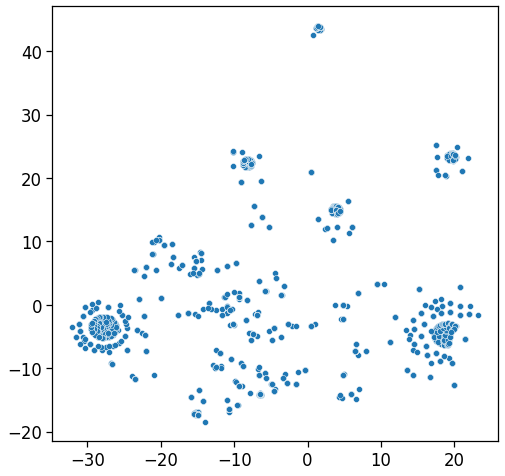

In [ ]:
from sklearn.manifold import TSNE
import seaborn as sns

tsne_x = TSNE(n_components=2, verbose=2, early_exaggeration=12.0, perplexity=50).fit_transform(fm_item_features.toarray()[:, -17:])

plt.figure(figsize=(8, 8))
sns.set_context("notebook", font_scale=1.5,
                rc={"lines.linewidth": 2.5})

sns.scatterplot(tsne_x[:, 0], tsne_x[:, 1])
plt.show()

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


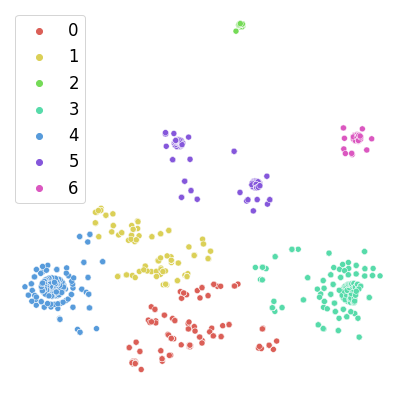

In [ ]:
from sklearn.cluster import KMeans

y = KMeans(n_clusters=7).fit_predict(tsne_x)
plt.figure(figsize=(7, 7))
plt.axis('off')
sns.scatterplot(tsne_x[:, 0], tsne_x[:, 1], hue=y, palette=sns.color_palette("hls", len(set(y))))
plt.show()

In [ ]:
'''
Checking clustering
'''
tag_cols = tags.columns[-17:]
for i in set(y):
  idx = np.where(y==i)[0].tolist()
  print(f"\n\nCluster: {i}")
  tag_counts = np.zeros(17)
  for movie_idx in idx:
    tag_counts += tags.iloc[movie_idx].values[-17:].astype(int)
  print(tag_cols[np.argsort(tag_counts)[::-1][:3]].tolist())



Cluster: 0
['Drama', 'Western', 'Childrens']


Cluster: 1
['Action', 'War', 'Horror']


Cluster: 2
['Romance', 'Drama', 'Comedy']


Cluster: 3
['Comedy', 'Childrens', 'Adventure']


Cluster: 4
['Drama', 'Comedy', 'Crime']


Cluster: 5
['Documentary', 'Western', 'Drama']


Cluster: 6
['War', 'Drama', 'Crime']


In [ ]:
print(y.shape)

(1682,)


In [ ]:
def run_lightfm(loss_fn, l2, lr, eps, train_set, test_set, feature_set):
  model = LightFM(loss=loss_fn, item_alpha=l2, learning_rate=lr)
  model.fit(train_set, item_features=feature_set, epochs=eps, num_threads=2, verbose=False)
  preds = model.predict_rank(test_set, train_interactions=train_set, item_features=feature_set)

  hr, mrr, ndcg = 0.0, 0.0, 0.0
  counter = 0
  for u, i in zip(*test_set.nonzero()):
    if preds[u, i] < 50 and preds[u, i] > 0:
      hr += 1
      mrr += (1/preds[u,i])
      ndcg += (math.log(2) / math.log(preds[u, i] + 2))
    counter += 1
  hr = hr*100/counter
  mrr = mrr/counter
  ndcg = ndcg/counter

  print(f'Hit Rate: {hr:.4f} \tMRR: {mrr:.4f} \tNDCG: {ndcg:.4f}\n')
  return hr, mrr, ndcg
  
def optimize_lightfm(args):
  hr, mrr, ndcg = run_lightfm(args['loss_fn'], args['l2'], args['lr'], args['epochs'], 
                               fm_train_for_val, fm_val, fm_item_features)

  print(f"Params: Loss Fn={args['loss_fn']}, Epochs={args['epochs']}, L2={args['l2']}, LR={args['lr']}")
  return -hr

space = {
    'loss_fn': hp.choice('loss_fn', ['bpr', 'logistic', 'warp']),
    'lr': hp.choice('lr', [0.05, 0.01]),
    'l2': hp.choice('l2', [1e-4, 1e-6]),
    'epochs': hp.choice('epochs', [20, 50, 100])
}

trials_fm = Trials()
best_fm = fmin(optimize_lightfm, space=space, algo=tpe.suggest, max_evals=50, trials=trials_fm)
print(best_fm)
print(trials_fm)

Hit Rate: 28.9502 	MRR: 0.0388 	NDCG: 0.0787

Params: Loss Fn=warp, Epochs=50, L2=0.0001, LR=0.01
Hit Rate: 7.3171 	MRR: 0.0050 	NDCG: 0.0169

Params: Loss Fn=logistic, Epochs=50, L2=1e-06, LR=0.05
Hit Rate: 7.3171 	MRR: 0.0049 	NDCG: 0.0167

Params: Loss Fn=logistic, Epochs=100, L2=1e-06, LR=0.01
Hit Rate: 18.1336 	MRR: 0.0250 	NDCG: 0.0498

Params: Loss Fn=bpr, Epochs=20, L2=1e-06, LR=0.01
Hit Rate: 24.9205 	MRR: 0.0292 	NDCG: 0.0650

Params: Loss Fn=warp, Epochs=20, L2=1e-06, LR=0.01
Hit Rate: 32.9799 	MRR: 0.0511 	NDCG: 0.0926

Params: Loss Fn=bpr, Epochs=100, L2=0.0001, LR=0.05
Hit Rate: 5.6204 	MRR: 0.0033 	NDCG: 0.0128

Params: Loss Fn=logistic, Epochs=50, L2=0.0001, LR=0.01
Hit Rate: 32.0255 	MRR: 0.0467 	NDCG: 0.0892

Params: Loss Fn=bpr, Epochs=20, L2=1e-06, LR=0.05
Hit Rate: 24.0721 	MRR: 0.0294 	NDCG: 0.0634

Params: Loss Fn=warp, Epochs=20, L2=0.0001, LR=0.01
Hit Rate: 15.9067 	MRR: 0.0188 	NDCG: 0.0422

Params: Loss Fn=bpr, Epochs=20, L2=0.0001, LR=0.01
Hit Rate: 19.7243 

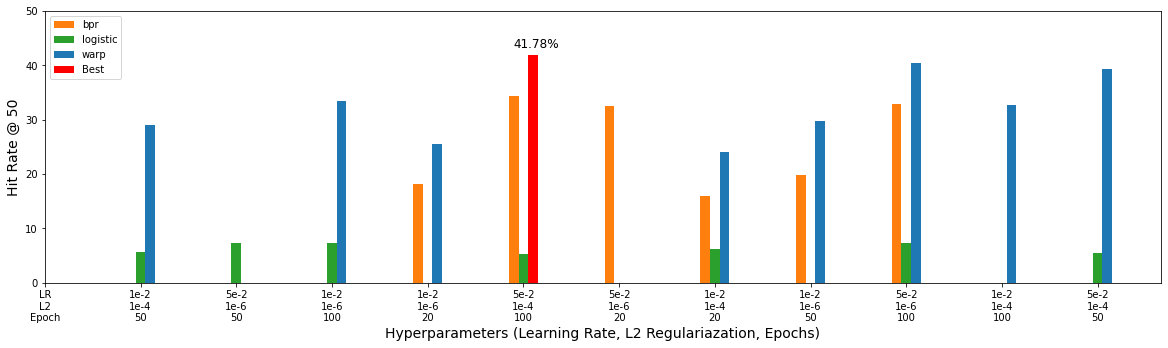

In [ ]:
lr = ['5e-2', '1e-2']
l2 = ['1e-4', '1e-6']
epochs = ['20', '50', '100']
loss_fn = ['bpr', 'logistic', 'warp']

points = {}
for t in trials_fm:
  point = (lr[t['misc']['vals']['lr'][0]], l2[t['misc']['vals']['l2'][0]], epochs[t['misc']['vals']['epochs'][0]])
  if not point in points:
    points[point] = {}
  loss_idx = loss_fn[t['misc']['vals']['loss_fn'][0]]
  curr_hr = points[point][loss_idx] if loss_idx in points[point] else -1
  points[point][loss_idx] = max([-t['result']['loss'], curr_hr])

plot = {'x_labels': [f"LR\nL2\nEpoch"]}
plot.update({fn: [[], []] for fn in loss_fn})

best_hr = 0
best_point = None
best_loss_fn = None
for idx, (k, v) in enumerate(points.items()):
  plot['x_labels'].append(f"{k[0]}\n{k[1]}\n{k[2]}")
  for fn, hr in v.items():
    plot[fn][0].append(idx + 1)
    plot[fn][1].append(hr)
    if hr > best_hr:
      best_point = idx + 1
      best_hr = hr
      best_loss_fn = fn

plt.figure(figsize=(20, 5))
offset = [-0.1, 0, 0.1]
for fn, c, off in zip(loss_fn, ['#ff7f0e','#2ca02c','#1f77b4'], offset):
  plt.bar(np.asarray(plot[fn][0]) + off, plot[fn][1], label=fn, width=0.1, color=c)
plt.bar(best_point + offset[loss_fn.index(best_loss_fn)], best_hr, label='Best', width=0.1, color='r')
plt.annotate(f"{best_hr:.2f}%", (best_point - 0.1, best_hr + 1.5), fontsize=12)
plt.xticks(range(len(points) + 1), plot['x_labels'])
plt.xlabel('Hyperparameters (Learning Rate, L2 Regulariazation, Epochs)', fontsize=14)
plt.ylabel('Hit Rate @ 50', fontsize=14)
plt.ylim((0, 50))
_ = plt.legend()

In [ ]:
def run_lightfm(loss_fn, l2, lr, eps, train_set, test_set, feature_set):
  model = LightFM(loss=loss_fn, item_alpha=l2, learning_rate=lr)
  model.fit(train_set, item_features=feature_set, epochs=eps, num_threads=2, verbose=False)
  preds = model.predict_rank(test_set, train_interactions=train_set, item_features=feature_set)

  hr, mrr, ndcg = 0.0, 0.0, 0.0
  counter = 0
  for u, i in zip(*test_set.nonzero()):
    if preds[u, i] < 50 and preds[u, i] > 0:
      hr += 1
      mrr += (1/preds[u,i])
      ndcg += (math.log(2) / math.log(preds[u, i] + 2))
    counter += 1
  hr = hr*100/counter
  mrr = mrr/counter
  ndcg = ndcg/counter

  print(f'Hit Rate: {hr:.4f} \tMRR: {mrr:.4f} \tNDCG: {ndcg:.4f}\n')
  return hr, mrr, ndcg
  
def optimize_implicit(args):
  hr, mrr, ndcg = run_lightfm(args['loss_fn'], args['l2'], args['lr'], args['epochs'], 
                               fm_train_for_val, fm_val, None)

  print(f"Params: Loss Fn={args['loss_fn']}, Epochs={args['epochs']}, L2={args['l2']}, LR={args['lr']}")
  return -hr

space = {
    'loss_fn': hp.choice('loss_fn', ['bpr', 'logistic', 'warp']),
    'lr': hp.choice('lr', [0.05, 0.01, 0.005, 0.001]),
    'l2': hp.choice('l2', [0, 1e-3, 1e-4, 1e-6]),
    'epochs': hp.choice('epochs', [10, 20, 50, 100])
}
# best = {'epochs': 2, 'l2': 1, 'loss_fn': 2, 'lr': 0}

trials_imp = Trials()
best_imp = fmin(optimize_implicit, space=space, algo=tpe.suggest, max_evals=50, trials=trials_imp)
print(best_imp)
print(trials_imp)

Hit Rate: 29.4804 	MRR: 0.0422 	NDCG: 0.0814

Params: Loss Fn=bpr, Epochs=50, L2=0.0001, LR=0.01
Hit Rate: 19.7243 	MRR: 0.0223 	NDCG: 0.0516

Params: Loss Fn=warp, Epochs=10, L2=0.0001, LR=0.005
Hit Rate: 21.4210 	MRR: 0.0272 	NDCG: 0.0579

Params: Loss Fn=warp, Epochs=20, L2=0.001, LR=0.001
Hit Rate: 31.1771 	MRR: 0.0430 	NDCG: 0.0848

Params: Loss Fn=warp, Epochs=50, L2=0, LR=0.01
Hit Rate: 33.0859 	MRR: 0.0408 	NDCG: 0.0873

Params: Loss Fn=bpr, Epochs=100, L2=1e-06, LR=0.01
Hit Rate: 18.1336 	MRR: 0.0242 	NDCG: 0.0486

Params: Loss Fn=bpr, Epochs=10, L2=0, LR=0.005
Hit Rate: 23.7540 	MRR: 0.0322 	NDCG: 0.0637

Params: Loss Fn=logistic, Epochs=100, L2=0, LR=0.01
Hit Rate: 40.4030 	MRR: 0.0550 	NDCG: 0.1096

Params: Loss Fn=warp, Epochs=100, L2=1e-06, LR=0.05
Hit Rate: 27.5716 	MRR: 0.0352 	NDCG: 0.0743

Params: Loss Fn=bpr, Epochs=100, L2=0.0001, LR=0.005
Hit Rate: 21.8452 	MRR: 0.0262 	NDCG: 0.0585

Params: Loss Fn=logistic, Epochs=20, L2=0.001, LR=0.01
Hit Rate: 23.4358 	MRR: 0.0

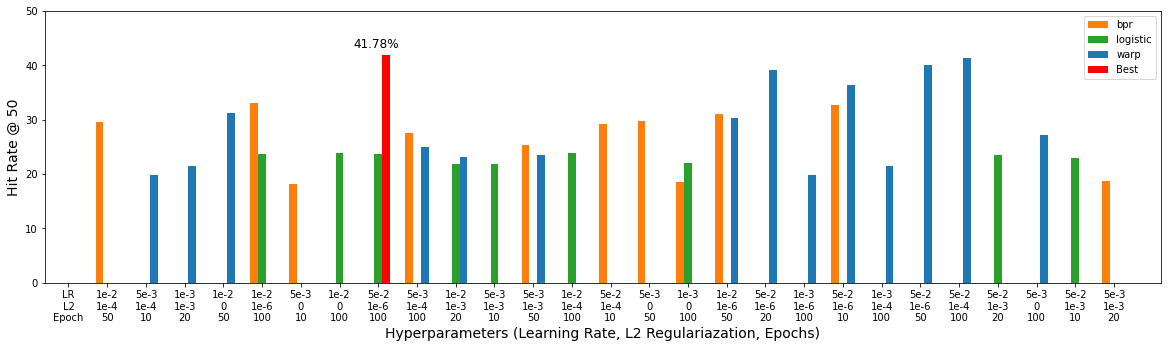

In [ ]:
lr = ['5e-2', '1e-2', '5e-3', '1e-3']
l2 = ['0', '1e-3', '1e-4', '1e-6']
epochs = ['10', '20', '50', '100']
loss_fn = ['bpr', 'logistic', 'warp']

points = {}
for t in trials_imp:
  point = (lr[t['misc']['vals']['lr'][0]], l2[t['misc']['vals']['l2'][0]], epochs[t['misc']['vals']['epochs'][0]])
  if not point in points:
    points[point] = {}
  loss_idx = loss_fn[t['misc']['vals']['loss_fn'][0]]
  curr_hr = points[point][loss_idx] if loss_idx in points[point] else -1
  points[point][loss_idx] = max([-t['result']['loss'], curr_hr])


plot = {'x_labels': [f"LR\nL2\nEpoch"]}
plot.update({fn: [[], []] for fn in loss_fn})

best_hr = 0
best_point = None
best_loss_fn = None
for idx, (k, v) in enumerate(points.items()):
  plot['x_labels'].append(f"{k[0]}\n{k[1]}\n{k[2]}")
  for fn, hr in v.items():
    plot[fn][0].append(idx + 1)
    plot[fn][1].append(hr)
    if hr > best_hr:
      best_point = idx + 1
      best_hr = hr
      best_loss_fn = fn

plt.figure(figsize=(20, 5))
offset = [-0.2, 0, 0.2]
for fn, c, off in zip(loss_fn, ['#ff7f0e','#2ca02c','#1f77b4'], offset):
  plt.bar(np.asarray(plot[fn][0]) + off, plot[fn][1], label=fn, width=0.2, color=c)
plt.bar(best_point + offset[loss_fn.index(best_loss_fn)], best_hr, label='Best', width=0.2, color='r')
plt.annotate(f"{best_hr:.2f}%", (best_point - 0.65, best_hr + 1.4), fontsize=12)
plt.xticks(range(len(points) + 1), plot['x_labels'])
plt.xlabel('Hyperparameters (Learning Rate, L2 Regulariazation, Epochs)', fontsize=14)
plt.ylabel('Hit Rate @ 50', fontsize=14)
plt.ylim((0, 50))
_ = plt.legend()

In [ ]:
# '''
# LightFM with attributes on test set
# '''
# print('WITH ITEM ATTRIBUTES')
# hr, mrr, ndcg = run_lightfm('warp', 0, 0.05, 100,
#                                fm_train, fm_test, fm_item_features)

# '''
# LightFM without attributes on test set
# '''
# print('NO ITEM ATTRIBUTES')
# hr, mrr, ndcg = run_lightfm('warp', 0, 0.05, 100,
#                                fm_train, fm_test, None)

# WITH ITEM ATTRIBUTES
# Hit Rate: 37.2216 	MRR: 0.0620 	NDCG: 0.1075

# NO ITEM ATTRIBUTES
# Hit Rate: 36.5854 	MRR: 0.0559 	NDCG: 0.1026

'''
LightFM with attributes on test set
'''
print('WITH ITEM ATTRIBUTES')
hr, mrr, ndcg = run_lightfm('warp', 1e-4, 0.05, 100,
                               fm_train, fm_test, fm_item_features)

'''
LightFM without attributes on test set
'''
print('NO ITEM ATTRIBUTES')
hr, mrr, ndcg = run_lightfm('warp', 1e-6, 0.05, 100,
                               fm_train, fm_test, None)

WITH ITEM ATTRIBUTES
Hit Rate: 36.3733 	MRR: 0.0581 	NDCG: 0.1035

NO ITEM ATTRIBUTES
Hit Rate: 35.7370 	MRR: 0.0540 	NDCG: 0.1006



In [ ]:
transition_mat = np.zeros((data_train['itemId'].max() + 1,
                           data_train['itemId'].max() + 1))

# Movies seen by User in training
seen_movies = data_train.groupby(by='userId')['itemId'].apply(list).to_dict()

# Creating a markov chain for movie transitions (Ranking)
for _, grp in data_train.groupby('userId'):
  items = grp['itemId'].tolist()
  for i in range(len(items) - 1):
    transition_mat[items[i]][items[i+1]] += 1

last_items = data_train.groupby(by='userId').tail(1)
last_items = dict(zip(last_items['userId'].tolist(), last_items['itemId'].tolist()))

# Conditional Probability Model
cp_preds = {} 
for u, i in last_items.items():
  preds = np.copy(transition_mat[i])
  cp_preds[u] = np.argsort(preds)[::-1][:50]
print('-------------Conditional Probability--------')
print_scores(spotlight_test.user_ids, spotlight_test.item_ids, cp_preds)

# Conditional Probability Model without Seen
cp_preds = {} 
for u, i in last_items.items():
  preds = np.copy(transition_mat[i])
  preds[seen_movies[u]] = 0
  cp_preds[u] = np.argsort(preds)[::-1][:50]
print('-------------Conditional Probability w/o Seen--------')
print_scores(spotlight_test.user_ids, spotlight_test.item_ids, cp_preds)

-------------Conditional Probability--------
Hit Rate (%): 27.465535524920465
MRR: 0.0489
NDCG: 0.0930

-------------Conditional Probability w/o Seen--------
Hit Rate (%): 29.90455991516437
MRR: 0.0662
NDCG: 0.1126



(29.90455991516437, 0.0662424416028655, 0.11260140238674064)

In [ ]:
# print(data_val.head())
print(last_items)
print(seen_movies[1][-5:])

{1: 74, 2: 314, 3: 317, 4: 294, 5: 442, 6: 465, 7: 357, 8: 227, 9: 487, 10: 294, 11: 51, 12: 88, 13: 914, 14: 750, 15: 931, 16: 404, 17: 508, 18: 923, 19: 211, 20: 94, 21: 573, 22: 29, 23: 315, 24: 742, 25: 1, 26: 181, 27: 370, 28: 678, 29: 1019, 30: 683, 31: 498, 32: 628, 33: 323, 34: 289, 35: 332, 36: 878, 37: 172, 38: 672, 39: 748, 40: 343, 41: 1, 42: 845, 43: 316, 44: 176, 45: 820, 46: 50, 47: 995, 48: 98, 49: 403, 50: 544, 51: 679, 52: 204, 53: 546, 54: 634, 55: 89, 56: 395, 57: 56, 58: 191, 59: 243, 60: 15, 61: 342, 62: 401, 63: 79, 64: 231, 65: 185, 66: 249, 67: 833, 68: 409, 69: 12, 70: 408, 71: 197, 72: 479, 73: 246, 74: 13, 75: 190, 76: 582, 77: 97, 78: 411, 79: 370, 80: 237, 81: 544, 82: 834, 83: 406, 84: 98, 85: 182, 86: 270, 87: 87, 88: 1191, 89: 301, 90: 385, 91: 418, 92: 1023, 93: 934, 94: 302, 95: 78, 96: 1154, 97: 663, 98: 629, 99: 275, 100: 326, 101: 546, 102: 1052, 103: 96, 104: 827, 105: 264, 106: 275, 107: 259, 108: 121, 109: 395, 110: 364, 111: 305, 112: 891, 113:

In [ ]:
'''
Explicit Feedback Movie Recommendations 
Rating Model
Made popular by Netflix Prize - Simon Funk
'''
spotlight_train_for_val.ratings = spotlight_train_for_val.ratings.astype(float)
spotlight_val.ratings = spotlight_val.ratings.astype(float)
def optimize_explicit(args):
  explicit_model = ExplicitFactorizationModel(loss=args['loss_fn'],
                                   l2=args['l2'], 
                                   learning_rate=args['lr'],
                                   n_iter=args['epochs'],
                                   use_cuda=True)

  print(f"loss={args['loss_fn']}\t epochs={args['epochs']}\t l2={args['l2']}\t lr={args['lr']}")
  explicit_model.fit(spotlight_train_for_val, verbose=False)
  rmse = rmse_score(explicit_model, spotlight_val)
  return rmse

space = {
    'loss_fn': hp.choice('loss_fn', ['regression', 'poisson', 'logistic']),
    'lr': hp.choice('lr', [0.01, 0.005, 0.001]),
    'l2': hp.choice('l2', [1e-3, 1e-4, 1e-6]),
    'epochs': hp.choice('epochs', [5, 10, 20, 50])
}

trials_ex = Trials()
best_ex = fmin(optimize_explicit, space=space, algo=tpe.suggest, max_evals=50, trials=trials_ex)
print(best_ex)
print(trials_ex)

loss=poisson	 epochs=50	 l2=1e-06	 lr=0.005
loss=logistic	 epochs=20	 l2=0.0001	 lr=0.001
  2%|▏         | 1/50 [00:40<33:17, 40.77s/it, best loss: 1.4733928033484116]

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))



loss=logistic	 epochs=50	 l2=1e-06	 lr=0.005
loss=poisson	 epochs=5	 l2=0.0001	 lr=0.005
loss=poisson	 epochs=50	 l2=0.0001	 lr=0.01
loss=regression	 epochs=50	 l2=0.0001	 lr=0.01
loss=regression	 epochs=5	 l2=0.001	 lr=0.01
loss=logistic	 epochs=50	 l2=1e-06	 lr=0.005
loss=poisson	 epochs=5	 l2=0.001	 lr=0.01
loss=regression	 epochs=50	 l2=0.001	 lr=0.01
loss=logistic	 epochs=20	 l2=0.0001	 lr=0.005
loss=regression	 epochs=20	 l2=0.001	 lr=0.005
loss=regression	 epochs=20	 l2=0.001	 lr=0.005
loss=poisson	 epochs=20	 l2=0.0001	 lr=0.005
loss=regression	 epochs=5	 l2=1e-06	 lr=0.001
loss=regression	 epochs=20	 l2=1e-06	 lr=0.001
loss=regression	 epochs=10	 l2=0.001	 lr=0.001
loss=poisson	 epochs=10	 l2=0.0001	 lr=0.01
loss=poisson	 epochs=20	 l2=1e-06	 lr=0.005
loss=regression	 epochs=50	 l2=0.0001	 lr=0.001
loss=poisson	 epochs=20	 l2=1e-06	 lr=0.001
loss=poisson	 epochs=20	 l2=1e-06	 lr=0.001
loss=poisson	 epochs=20	 l2=1e-06	 lr=0.001
loss=regression	 epochs=20	 l2=0.0001	 lr=0.001
l

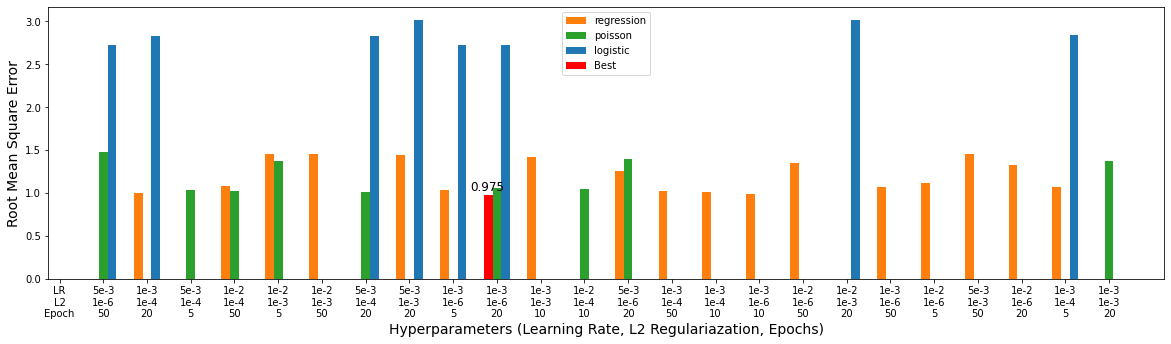

In [ ]:
lr = ['1e-2', '5e-3', '1e-3']
l2 = ['1e-3', '1e-4', '1e-6']
epochs = ['5', '10', '20', '50']
loss_fn = ['regression', 'poisson', 'logistic']

points = {}
for t in trials_ex:
  point = (lr[t['misc']['vals']['lr'][0]], l2[t['misc']['vals']['l2'][0]], epochs[t['misc']['vals']['epochs'][0]])
  if not point in points:
    points[point] = {}
  loss_idx = loss_fn[t['misc']['vals']['loss_fn'][0]]
  curr_rmse = points[point][loss_idx] if loss_idx in points[point] else float('inf')
  points[point][loss_idx] = min([t['result']['loss'], curr_rmse])

plot = {'x_labels': [f"LR\nL2\nEpoch"]}
plot.update({fn: [[], []] for fn in loss_fn})

best_rmse = float('inf')
best_point = None
best_loss_fn = None
for idx, (k, v) in enumerate(points.items()):
  plot['x_labels'].append(f"{k[0]}\n{k[1]}\n{k[2]}")
  for fn, rmse in v.items():
    plot[fn][0].append(idx + 1)
    plot[fn][1].append(rmse)
    if rmse < best_rmse:
      best_point = idx + 1
      best_rmse = rmse
      best_loss_fn = fn


plt.figure(figsize=(20, 5))
offset = [-0.2, 0, 0.2]
for fn, c, off in zip(loss_fn, ['#ff7f0e','#2ca02c','#1f77b4'], offset):
  plt.bar(np.asarray(plot[fn][0]) + off, plot[fn][1], label=fn, width=0.2, color=c)
plt.bar(best_point + offset[loss_fn.index(best_loss_fn)], best_rmse, label='Best', width=0.2, color='r')
plt.annotate(f"{best_rmse:.3f}", (best_point - 0.6, best_rmse + 5e-2), fontsize=12)


# for fn, c in zip(loss_fn, ['#2ca02c','#ff7f0e','#1f77b4']):
#   plt.plot(plot[fn][0], plot[fn][1], '.-', label=fn, markersize=15, linewidth=2, color=c)
# plt.scatter(best_point, best_rmse, label='Best', s=250, c='r')
# plt.annotate(f"{best_rmse:.3f}", (best_point - 0.175, best_rmse + 1e-2), fontsize=12)
plt.xticks(range(len(points) + 1), plot['x_labels'])
plt.xlabel('Hyperparameters (Learning Rate, L2 Regulariazation, Epochs)', fontsize=14)
plt.ylabel('Root Mean Square Error', fontsize=14)
plt.legend()
plt.show()

In [ ]:
def rating_scores(real, preds, show=True):
  diff = np.abs(real - preds)
  mae = np.average(diff)
  rmse = math.sqrt(np.average(diff ** 2))
  if show:
    print(f'MAE: {mae:.4f}\t RMSE: {rmse:.4f}')
  return mae, rmse

'''
Rating Explicit Feedback Model scores
'''
explicit_model = ExplicitFactorizationModel(loss='regression',
                                   l2=1e-6, 
                                   learning_rate=1e-3,
                                   n_iter=20, use_cuda=False)

explicit_model.fit(spotlight_train, verbose=False)

ex_preds = []
for uid, iid in zip(spotlight_test.user_ids, spotlight_test.item_ids):
  ex_preds.append(explicit_model.predict(uid)[iid])
print('Explicit feedback Rating')
rating_scores(spotlight_test.ratings, np.array(ex_preds))

'''
Rating Baseline
'''
user_avg_rating = data_train.groupby(by='userId')['ratings'].mean()

print('\nUser Avg Rating')
rating_scores(data_test['ratings'].to_numpy(), user_avg_rating.to_numpy())

print('\nGlobal Avg Rating')
_ = rating_scores(data_test['ratings'].to_numpy(), np.ones_like(user_avg_rating)*data_train['ratings'].mean())


Explicit feedback Rating
MAE: 0.7913	 RMSE: 1.0191

User Avg Rating
MAE: 0.9185	 RMSE: 1.1563

Global Avg Rating
MAE: 1.0164	 RMSE: 1.2121


Explicit feedback Rating
MAE: 0.8041	 RMSE: 1.0266

User Avg Rating
MAE: 0.9185	 RMSE: 1.1563

Global Avg Rating
MAE: 1.0164	 RMSE: 1.2121

In [ ]:
def get_top_n(preds, n=10):
  return np.argsort(preds)[::-1][:n]

def print_scores(test_user_ids, test_item_ids, preds, show=True):
  hr = 0.0
  mrr = 0.0
  ndcg = 0.0
  for u, i in zip(test_user_ids, test_item_ids):
    temp_hr = int(i in preds[u])
    if temp_hr:
      rank = preds[u].tolist().index(i)
      hr += 1
      mrr += 1 / (rank + 1)
      ndcg += (math.log(2) / math.log(rank + 2))

  hr = (hr / len(test_user_ids)) * 100
  mrr = mrr / len(test_user_ids)
  ndcg = ndcg / len(test_user_ids)

  if show:
    print(f"Hit Rate (%): {hr}")
    print(f"MRR: {mrr:.4f}")
    print(f"NDCG: {ndcg:.4f}\n")
  return hr, mrr, ndcg

In [ ]:
# explicit_top_50 = {}
# implicit_top_50 = {}

# for uid in set(spotlight_train.user_ids):
#   # explicit_scores = explicit_model.predict(uid)
#   # explicit_scores[seen_movies[uid]] = -1
#   implicit_scores = implicit_model.predict(uid)
#   implicit_scores[seen_movies[uid]] = 0

#   # explicit_top_50[uid] = get_top_n(explicit_scores, n=50)
#   implicit_top_50[uid] = get_top_n(implicit_scores, n=50)

# print('-------------Most Popular--------')
# print_scores(spotlight_test.user_ids, spotlight_test.item_ids, mp_preds)

# print('----------Explicit----------')
# print_scores(spotlight_test.user_ids, spotlight_test.item_ids, explicit_top_50)

# print('-------------Implicit--------')
# print_scores(spotlight_test.user_ids, spotlight_test.item_ids, implicit_top_50)

print('-------------Conditional Probability--------')
print_scores(spotlight_test.user_ids, spotlight_test.item_ids, cp_preds)

# print('-------------Conditional Probability + Most Popular--------')
# _ = print_scores(spotlight_test.user_ids, spotlight_test.item_ids, cp_mp_preds)

-------------Conditional Probability--------
Hit Rate (%): 19.300106044538705
MRR: 0.0150
NDCG: 0.0483



(19.300106044538705, 0.015034974619888616, 0.04829416429456377)

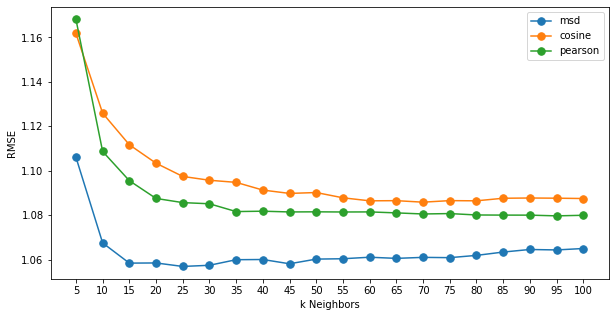

In [ ]:
'''
KNN Basic (Rating)
'''
k_list = [k for k in range(5,101,5)]
rmse_all = {}

for sim_func in ['msd', 'cosine', 'pearson']:
  rmse_list = []
  for k in k_list:
    knn = KNNBasic(k, sim_options={'name': sim_func, 'user_based': True}, verbose=False)
    knn.fit(DatasetAutoFolds.build_full_trainset(surprise_train))
    preds = knn.test(surprise_test)
  
    # print(f'\n-------------KNN({sim_func.upper()}, k={k}) -------------')
    mae, rmse = rating_scores(np.array([p[2] for p in preds]), np.array([p[3] for p in preds]), show=False)
    rmse_list.append(rmse)
  rmse_all[sim_func] = rmse_list

plt.figure(figsize=(10,5))
for label,value in rmse_all.items():
  plt.plot(k_list, value, '.-', markersize=15, label=label)
plt.xticks(k_list)
plt.xlabel('k Neighbors')
plt.ylabel('RMSE')
plt.legend()
plt.show()


In [ ]:
def rating_scores(real, preds, show=True):
  diff = np.abs(real - preds)
  mae = np.average(diff)
  rmse = math.sqrt(np.average(diff ** 2))
  if show:
    print(f'MAE: {mae:.4f}\t RMSE: {rmse:.4f}')
  return mae, rmse

'''
KNN Basic (Rating)
'''
def optimize_knn(args):
  algorithm = KNNBasic(k=args['k'], min_k=args['min_k'], sim_options={'name': args['sim_func'], 'user_based': True}, verbose=False)
  algorithm.fit(DatasetAutoFolds.build_full_trainset(surprise_train_for_val))
  preds = algorithm.test(surprise_val)
  mae, rmse = rating_scores(np.array([p[2] for p in preds]), np.array([p[3] for p in preds]), show=False)
  return rmse


space = {
    'sim_func': hp.choice('sim_func', ['msd', 'cosine', 'pearson']),
    'min_k': hp.choice('min_k', [1, 2, 5, 10]),
    'k': hp.choice('k', list(range(5, 81, 5)))
}

trials_knn = Trials()
best_knn = fmin(optimize_knn, space=space, algo=tpe.suggest, max_evals=50, trials=trials_knn)
print(best_knn)
print(trials_knn)

100%|██████████| 50/50 [00:37<00:00,  1.32it/s, best loss: 1.0095241254500262]
{'k': 5, 'min_k': 1, 'sim_func': 0}


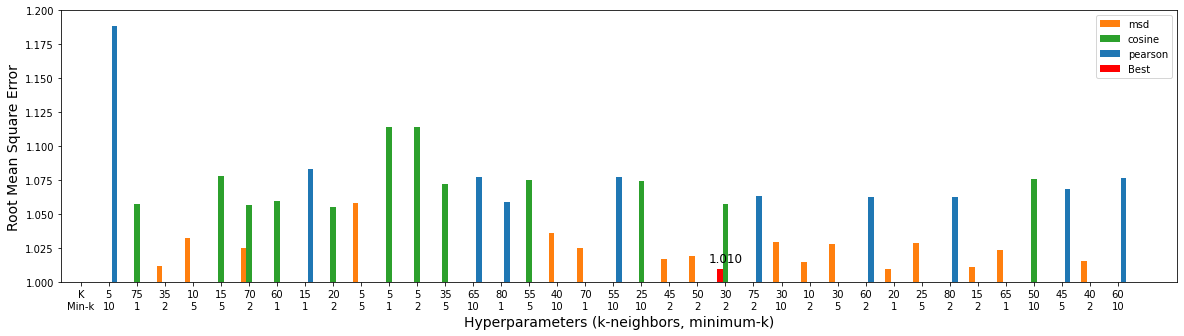

In [ ]:
sim_functions = ['msd', 'cosine', 'pearson']
k_list = list(range(5, 81, 5))
min_k = [1, 2, 5, 10]

points = {}
for t in trials_knn:
  point = (k_list[t['misc']['vals']['k'][0]], min_k[t['misc']['vals']['min_k'][0]])
  if not point in points:
    points[point] = {}
  points[point][sim_functions[t['misc']['vals']['sim_func'][0]]] = t['result']['loss']

plot = {'x_labels': [f"K\nMin-k"]}
plot.update({fn: [[], []] for fn in sim_functions})

best_rmse = float('inf')
best_point = None
best_sim_functions = None
for idx, (k, v) in enumerate(points.items()):
  plot['x_labels'].append(f"{k[0]}\n{k[1]}")
  for fn, rmse in v.items():
    plot[fn][0].append(idx + 1)
    plot[fn][1].append(rmse)
    if rmse < best_rmse:
      best_point = idx + 1
      best_rmse = rmse
      best_sim_functions = fn


plt.figure(figsize=(20, 5))
offset = [-0.2, 0, 0.2]
for fn, c, off in zip(sim_functions, ['#ff7f0e','#2ca02c','#1f77b4'], offset):
  plt.bar(np.asarray(plot[fn][0]) + off, plot[fn][1], label=fn, width=0.2, color=c)
plt.bar(best_point + offset[sim_functions.index(best_sim_functions)], best_rmse, label='Best', width=0.2, color='r')
plt.annotate(f"{best_rmse:.3f}", (best_point - 0.6, best_rmse + 5e-3), fontsize=12)
plt.xticks(range(len(points) + 1), plot['x_labels'])
plt.xlabel('Hyperparameters (k-neighbors, minimum-k)', fontsize=14)
plt.ylabel('Root Mean Square Error', fontsize=14)
plt.ylim((1,1.2))
plt.legend()
plt.show()

In [ ]:
'''
Evaluating k-NN
'''
for best_k, mink, sim_func in [(30, 1, 'msd'), (35, 1, 'cosine'), (60, 1, 'pearson')]:
  print(f'Similarity={sim_func} \tk={best_k} \t Min_k={mink}')
  algorithm = KNNBasic(k=best_k, min_k=mink, sim_options={'name': sim_func, 'user_based': True}, verbose=False)
  algorithm.fit(DatasetAutoFolds.build_full_trainset(surprise_train))
  preds = algorithm.test(surprise_test)
  mae, rmse = rating_scores(np.array([p[2] for p in preds]), np.array([p[3] for p in preds]))
  print('\n')

Similarity=msd 	k=30 	 Min_k=1
MAE: 0.8349	 RMSE: 1.0575


Similarity=cosine 	k=35 	 Min_k=1
MAE: 0.8678	 RMSE: 1.0948


Similarity=pearson 	k=60 	 Min_k=1
MAE: 0.8534	 RMSE: 1.0815




In [ ]:
'''
Slope-One, Co-Clustering
'''
# Iterate over all algorithms
for algorithm in [SlopeOne(), NormalPredictor(), CoClustering()]:
  algorithm.fit(DatasetAutoFolds.build_full_trainset(surprise_train))
  preds = algorithm.test(surprise_test)

  print(f'\n-------------{str(algorithm)} -------------')
  rating_scores(np.array([p[2] for p in preds]), np.array([p[3] for p in preds]))
  # top_50 = {}
  # for uid, iid, r in surprise_test:
  #   p = [algorithm.predict(uid, i)[3] if i not in seen_movies[uid] and i!=0 else -1 for i in range(spotlight_train.num_items)]
  #   top_50[uid] = get_top_n(p, n=50)

  # print_scores(spotlight_test.user_ids, spotlight_test.item_ids, knn_top_50)


-------------<surprise.prediction_algorithms.slope_one.SlopeOne object at 0x7fd95782ab00> -------------
MAE: 0.7961, RMSE: 1.0277

-------------<surprise.prediction_algorithms.random_pred.NormalPredictor object at 0x7fd95782a1d0> -------------
MAE: 1.2861, RMSE: 1.6059

-------------<surprise.prediction_algorithms.co_clustering.CoClustering object at 0x7fd95782a320> -------------
MAE: 0.8249, RMSE: 1.0581


In [ ]:
def run_cocluster(train_set, test_set, u_cluster, i_cluster, epoch):
  algorithm = CoClustering(n_cltr_u=u_cluster, n_cltr_i=i_cluster, n_epochs=epoch)
  algorithm.fit(DatasetAutoFolds.build_full_trainset(train_set))
  preds = algorithm.test(test_set)
  mae, rmse = rating_scores(np.array([p[2] for p in preds]), np.array([p[3] for p in preds]), show=False)
  return mae, rmse

def optimize_cocluster(args):
  mae, rmse = run_cocluster(surprise_train_for_val, surprise_val, args['u_clusters'], args['i_clusters'],args['epochs'])
  return rmse

space = {
    'u_clusters': hp.choice('u_clusters', [2, 3, 5, 10, 20]),
    'i_clusters': hp.choice('i_clusters', [2, 3, 5, 10, 20]),
    'epochs': hp.choice('epochs', [10, 15, 20, 30, 50])
}

trials_co = Trials()
best_co = fmin(optimize_cocluster, space=space, algo=tpe.suggest, max_evals=50, trials=trials_co)
print(best_co)
print(trials_co)


100%|██████████| 50/50 [01:40<00:00,  2.00s/it, best loss: 1.009491879752358]
{'epochs': 1, 'i_clusters': 1, 'u_clusters': 3}


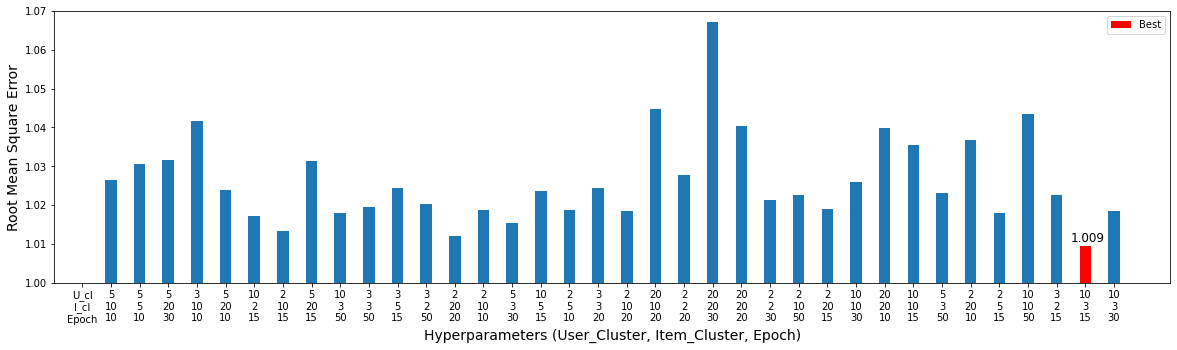

In [ ]:
u_clusters=[2, 3, 5, 10, 20]
i_clusters=[2, 3, 5, 10, 20]
epochs=[10, 15, 20, 30, 50]

points = {}
for t in trials_co:
  point = (u_clusters[t['misc']['vals']['u_clusters'][0]], i_clusters[t['misc']['vals']['i_clusters'][0]], epochs[t['misc']['vals']['epochs'][0]])
  if not point in points:
    points[point] = float('inf')
  points[point] = min([t['result']['loss'], points[point]])

plot = {'x_labels': [f"U_cl\nI_cl\nEpoch"], 'co-cluster': [[], []]}

best_rmse = float('inf')
best_point = None
for idx, (k, v) in enumerate(points.items()):
  plot['x_labels'].append(f"{k[0]}\n{k[1]}\n{k[2]}")
  plot['co-cluster'][0].append(idx + 1)
  plot['co-cluster'][1].append(v)
  if v < best_rmse:
    best_point = idx + 1
    best_rmse = v

plt.figure(figsize=(20, 5))
plt.bar(plot['co-cluster'][0], plot['co-cluster'][1], width=0.4)
plt.bar(best_point, best_rmse, label='Best', width=0.4, color='r')
# plt.scatter(best_point, best_rmse, label='Best', s=250, c='r')
plt.annotate(f"{best_rmse:.3f}", (best_point - 0.5, best_rmse + 1e-3), fontsize=12)
plt.xticks(range(len(points) + 1), plot['x_labels'])
plt.xlabel('Hyperparameters (User_Cluster, Item_Cluster, Epoch)', fontsize=14)
plt.ylabel('Root Mean Square Error', fontsize=14)
plt.ylim((1, 1.07))
plt.legend()
plt.show()

In [ ]:
mae, rmse = run_cocluster(surprise_train, surprise_test, 10, 3, 30)
print('Co-Cluster Results on Test')
print(f'MAE:{mae:.4f}\t RMSE:{rmse:.4f}')

Co-Cluster Results on Test
MAE:0.8140	 RMSE:1.0528


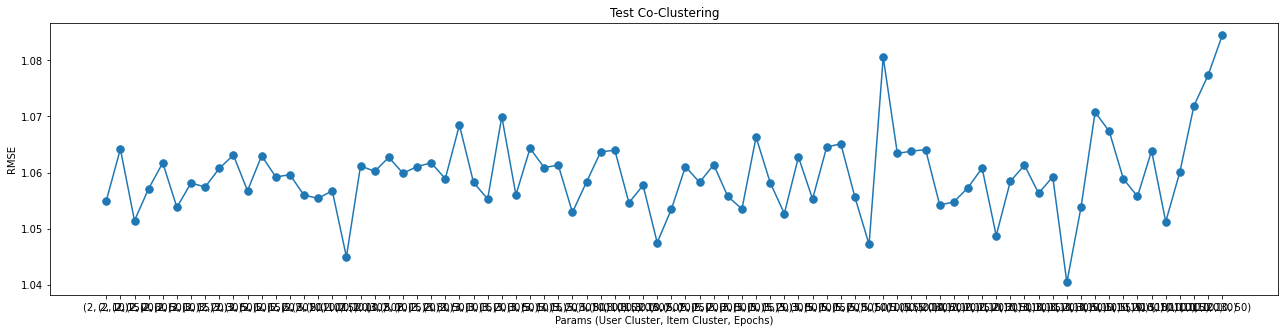

In [ ]:
'''
Co-Clustering
'''
mae_list, rmse_list, params = [], [], []

n_clusters = [2, 3, 5, 10]
n_epochs = [10, 15, 20, 30, 50]

for u in n_clusters:
  for i in n_clusters:
    for ep in n_epochs:
      algorithm = CoClustering(n_cltr_u=u, n_cltr_i=i, n_epochs=ep)
      algorithm.fit(DatasetAutoFolds.build_full_trainset(surprise_train))
      preds = algorithm.test(surprise_test)

      param = (u,i,ep)
      # print(f'\n-------------Co-Clustering{str(param)} -------------')
      mae, rmse = rating_scores(np.array([p[2] for p in preds]), np.array([p[3] for p in preds]), show=False)
      mae_list.append(mae)
      rmse_list.append(rmse)
      params.append(param)

plt.figure(figsize=(22,5))
plt.title('Test Co-Clustering')
plt.plot(range(len(params)), rmse_list, '.-', markersize=15)
plt.xticks(range(len(params)), labels=params)
plt.xlabel('Params (User Cluster, Item Cluster, Epochs)')
_ = plt.ylabel('RMSE')

In [ ]:
# Testing original LightFM

from lightfm.datasets import fetch_movielens

data_ml = fetch_movielens(min_rating=5.0)
model_x = LightFM(loss='warp')
%time model_x.fit(data_ml['train'], item_features=data_ml['item_features'], epochs=30, num_threads=2)
print("Train precision: %.2f" % precision_at_k(model_x, data_ml['train'], k=5).mean())
print("Test precision: %.2f" % precision_at_k(model_x, data_ml['test'], train_interactions=data_ml['train'], item_features=data_ml['item_features'], k=5).mean())
preds = model_x.predict_rank(data_ml['test'], train_interactions=data_ml['train'], item_features=data_ml['item_features'])
hr, mrr, ndcg = 0.0, 0.0, 0.0
counter = 0
for u, i in zip(*data_ml['test'].nonzero()):
  if preds[u, i] < 50 and preds[u, i] > 0:
    hr += 1
    mrr += (1/preds[u,i])
    ndcg += (math.log(2) / math.log(preds[u, i] + 2))
  counter += 1

print(f'Hit Rate: {hr*100/counter:.4f}')
print(f'MRR: {mrr/counter:.4f}')
print(f'NDCG: {ndcg/counter:.4f}')

print('-------------------------\n')
model_x = LightFM(loss='warp')
%time model_x.fit(data_ml['train'], epochs=30, num_threads=2)
print("Train precision: %.2f" % precision_at_k(model_x, data_ml['train'], k=5).mean())
print("Test precision: %.2f" % precision_at_k(model_x, data_ml['test'], train_interactions=data_ml['train'], k=5).mean())
preds = model_x.predict_rank(data_ml['test'], train_interactions=data_ml['train'], item_features=data_ml['item_features'])
hr, mrr, ndcg = 0.0, 0.0, 0.0
counter = 0
for u, i in zip(*data_ml['test'].nonzero()):
  if preds[u, i] < 50 and preds[u, i] > 0:
    hr += 1
    mrr += (1/preds[u,i])
    ndcg += (math.log(2) / math.log(preds[u, i] + 2))
  counter += 1

print(f'Hit Rate: {hr*100/counter:.4f}')
print(f'MRR: {mrr/counter:.4f}')
print(f'NDCG: {ndcg/counter:.4f}')

CPU times: user 733 ms, sys: 1.97 ms, total: 735 ms
Wall time: 376 ms
Train precision: 0.41
Test precision: 0.07
Hit Rate: 46.3075
MRR: 0.0812
NDCG: 0.1359
-------------------------

CPU times: user 741 ms, sys: 887 µs, total: 742 ms
Wall time: 385 ms
Train precision: 0.40
Test precision: 0.08
Hit Rate: 46.7255
MRR: 0.0784
NDCG: 0.1366


In [ ]:
'''
Just for sanity check
'''
from spotlight.sequence.implicit import ImplicitSequenceModel
from spotlight.interactions import SequenceInteractions

seq_train = spotlight_dataset.to_sequence(max_sequence_length=20)
seq_model = ImplicitSequenceModel(n_iter=10, representation='cnn', loss='hinge', use_cuda=True)
seq_model.fit(seq_train)

t = {}
seq_test_input = spotlight_dataset.to_sequence(max_sequence_length=1000)
for uid in range(spotlight_train.num_users - 1):
  p = seq_model.predict(seq_test_input.sequences[uid][-25:])
  t[uid+1] = get_top_n(p, n=50)

print_scores(spotlight_test.user_ids, spotlight_test.item_ids, t)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Hit Rate (%): 60.127253446447504
MRR: 0.1278745386505913
NDCG: 0.22118200837814286

